# Data downloading from Spotify

We would like to get the musical genre associated to an artist from Spotify.

## Spotify Authentication

In order to use the Spotify API, we need to register on their websites to obtain our client_id and secret. Then we can ask for a token allowing us to get the wanted information on the artists.

In [1]:
import spotipy
import spotipy.oauth2 as oauth2
import spotipy.util as util

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
client_id = "c829ff34022d4c3a9e65c30c10623765"
client_secret = "8e998357ebf04fe092edab4915946e00"

credentials = oauth2.SpotifyClientCredentials(client_id, client_secret)

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

### Mapping Artist to the Genres

Import the artists and already pre-defined genres in a pandas dataframe

In [37]:
filepath = "kaggleDataset\music.csv" #lyrics
lyrics_df = pd.read_csv(filepath)
useful_df = lyrics_df[['artist.name', 'terms']]
useful_df.head()

,artist.name,terms
0,Casual,hip hop
1,The Box Tops,blue-eyed soul
2,Sonora Santanera,salsa
3,Adam Ant,pop rock
4,Gob,pop punk


Fetch all the genres of the artists on Spotify

In [65]:
def get_artist_genres(artist_name):
    """ Fetch on Spotify the genres of the artist"""
    query = sp.search(q='artist:' + artist_name, type='artist')
    if len(query['artists']['items']) > 0:
        genres = query['artists']['items'][0]['genres'] # list: ["pop rock", "hard rock", "alternative rock"...]
        return genres
    else:
        #print("{} not on Spotify".format(artist_name))
        return []

    
artist_genre = []
artists = list(set(useful_df['artist.name']))

print("Initial number of artists: {}".format(len(artists)))
for i, artist in enumerate(artists):
    if i % 500 == 0:
        print(i)
    genres = get_artist_genres(artist)
    if len(genres) > 0:
        artist_genre.append([artist, genres])
print("Number of artists with genres on Spotify: {}".format(len(artist_genre)))

Initial number of artists: 2159
0
500
1000
1500
2000
Number of artists with genres on Spotify: 474


In [3]:
artist_genres_df = pd.DataFrame(artist_genre, columns = {'artist', 'genre'})
artist_genres_df.head()

,Unnamed: 0,artist,genre
0,0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']"
1,1,Jimmy Hughes,['southern soul']
2,2,Joy Division,"['alternative rock', 'art rock', 'dance rock',..."
3,3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '..."
4,4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk..."


Careful with the save as it overrides the actual file, thus I commented the line

In [71]:
# Save the genres:
# artist_genres_df.to_csv("../kaggleDataset/artist_genre.csv", sep=';')

### Getting one specific genre per artist: 

Given the artists genres obtained from Spotify, we want to reduce the large amount of genre possibilities provided by Spotify to only a few interesting ones such as pop, rock...

In [11]:
MAIN_GENRES = {'indie', 'metal', 'electronic', 'hip hop', 'country', 'jazz', 'pop', 'rock'}

artist_path = "../kaggleDataset/artist_genre.csv"
artist_genres_df = pd.read_csv(artist_path, sep = ';', usecols = ["artist", "genre"])
artist_genres_df.head() # The genre field is a string and not a list

,artist,genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']"
1,Jimmy Hughes,['southern soul']
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',..."
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '..."
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk..."


For each artist, we will now convert all the genres of Spotify to a unique one from our MAIN GENRES. 
For instance, Black Eyed Peas is categorised to be: dance pop, pop, pop rap from Spotify. We see that the term pop appears the most and he is one of our MAIN GENRES. Thus we will categorize Black Eed Peas genre as pop.

##### Careful: if the MAIN GENRES set changes, the artist's genre might change too !  

In [12]:
def get_main_genre(genres, main_genres = MAIN_GENRES):
    """ Count occurences of main genres terms in the genres string"""
    main_genres_occ = [(g, len(re.findall(g, genres))) for g in main_genres if len(re.findall(g, genres)) > 0] # list: [(rock, 3), (pop, 1), (hard, 1)...]
    
    if len(main_genres_occ) > 0:
        max_genre = sorted(main_genres_occ, key = lambda x: x[1], reverse = True)[0][0]
        return max_genre
    else:
        return "No main genre"

In [13]:
simple_genres = []
for i, artist_row in artist_genres_df.iterrows():
    genres = artist_row['genre']
    main_genre = get_main_genre(genres)
    simple_genres.append(main_genre)

col_name = "main genre"
if col_name in list(artist_genres_df.columns):
    artist_genres_df.drop(col_name, inplace = True)
artist_genres_df[col_name] = simple_genres
artist_genres_df.head()

,artist,genre,main genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']",pop
1,Jimmy Hughes,['southern soul'],No main genre
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',...",rock
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '...",pop
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk...",electronic


Number of artists: 2727
Number of artists with main genre: 1796
Ratio: 0.6585991932526586


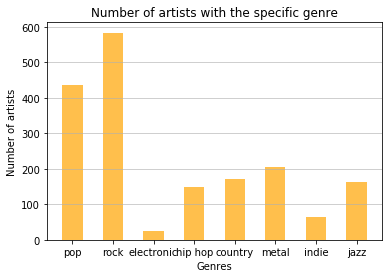

In [14]:
print("Number of artists: {}".format(len(artist_genres_df)))
genres_df = artist_genres_df[artist_genres_df["main genre"] != "No main genre"]
print("Number of artists with main genre: {}".format(len(genres_df)))
print("Ratio: {}".format(len(genres_df) / len(artist_genres_df)))

n, bins, patches = plt.hist(x = list(genres_df["main genre"]), bins=np.arange(0,len(MAIN_GENRES) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.show()

In [17]:
# Save the dataframe with main genre in a csv file
useful_df = genres_df[["artist", "main genre"]]
useful_df.to_csv("../kaggleDataset/artists_main_genre.csv", index = False)